Cloning the repo



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ClementPinard/FlowNetPytorch.git


Cloning into 'FlowNetPytorch'...
remote: Enumerating objects: 559, done.
remote: Counting objects: 100% (47/47), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 559 (delta 17), reused 30 (delta 14), pack-reused 512
Receiving objects: 100% (559/559), 1.23 MiB | 3.61 MiB/s, done.
Resolving deltas: 100% (313/313), done.


In [ ]:
%cd FlowNetPytorch/

/content/FlowNetPytorch


In [ ]:
pip install -r requirements.txt

Running pretrained model of flownet on flying chair dataset

In [ ]:
!python3 run_inference.py /content/ /content/FlowNetPytorch/flying_chairs/03-23-11:45/flownets,adam,10epochs,epochSize1000,b8,lr1e-05/model_best.pth.tar

Lucas kanade

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import math

In [ ]:
def pad(img,k):
  img=np.insert(img,img.shape[0],img[img.shape[0]-1,:],axis=0)
  img=np.insert(img,img.shape[1],img[:,img.shape[1]-1],axis=1)
  for i in range(k//2):
      img=np.insert(img,img.shape[0],img[img.shape[0]-1,:],axis=0)
      img=np.insert(img,img.shape[1],img[:,img.shape[1]-1],axis=1)
      img=np.insert(img,0,img[0,:],axis=0)
      img=np.insert(img,0,img[:,0],axis=1)
  return img

In [ ]:
def LN(str1,str2,str3):
  gt=np.load(str3)
  img_1=cv2.cvtColor(cv2.imread(str1),cv2.COLOR_BGR2GRAY).astype(np.float32)
  img_2=cv2.cvtColor(cv2.imread(str2),cv2.COLOR_BGR2GRAY).astype(np.float32)
  # plt.subplot(2, 3, 1)
  # plt.imshow(img_1, cmap = 'gray')
  # plt.subplot(2, 3, 2)
  # plt.imshow(img_2, cmap = 'gray')
  # plt.subplot(2, 3, 3)
  # plt.imshow(gt, cmap = 'gray')
  w=3
  for kernel in [3]:
      img1=pad(img_1,kernel)
      img2=pad(img_2,kernel)
      r,c=img1.shape
      I_x=np.zeros((r-1,c-1))
      I_y=np.zeros((r-1,c-1))
      I_t=np.zeros((r-1,c-1))
      for i in range(r-1):
        for j in range(c-1):
          I_x[i,j]=0.25*(img1[i+1,j]+img2[i+1,j]+img1[i+1,j+1]+img2[i+1,j+1]-(img1[i,j]+img2[i,j]+img1[i,j+1]+img2[i,j+1]))
          I_y[i,j]=0.25*(img1[i,j+1]+img2[i,j+1]+img1[i+1,j+1]+img2[i+1,j+1]-(img1[i,j]+img2[i,j]+img1[i+1,j]+img2[i+1,j]))
          I_t[i,j]=0.25*(img2[i,j+1]+img2[i+1,j+1]+img2[i+1,j]+img2[i,j]-(img1[i,j+1]+img1[i+1,j+1]+img1[i+1,j]+img1[i,j]))
      optical_flow=np.zeros((r-kernel,c-kernel))
      r,c=optical_flow.shape
      for i in range(kernel//2,r+kernel//2):
        for j in range(kernel//2,c+kernel//2):
          A=np.zeros((kernel*kernel,2))
          b=np.zeros((kernel*kernel,1))
          l=0
          for m in range(i-kernel//2,i+kernel//2+1):
            for n in range(j-kernel//2,j+kernel//2+1):
              A[l][0]=I_x[m,n]
              A[l][1]=I_y[m,n]
              b[l][0]=-I_t[m,n]
              l+=1
          h=(A.T@A)
          if (np.linalg.det(h)!=0):
            u=(np.linalg.inv(h)@A.T@b)
          else :
            u=np.array([[0],[0]])
          optical_flow[i-kernel//2,j-kernel//2]=((u[1,0])**2 + (u[0,0])**2 )**0.5
      w+=1
      MSE =np.square(optical_flow-gt).mean()
      print(f' For patch size = {kernel} X {kernel}, MSE = {MSE}.')

In [ ]:
LN("/content/img1.jpg","/content/img2.jpg","/content/GT1.npy")

 For patch size = 3 X 3, MSE = 71.72264556563962.


Calculating MSE between Lucas kanade flow output and Flownet optical flow output

In [ ]:
import numpy as np

# Load the .npy file into a numpy array
gt = np.load('GT1.npy')

import cv2

# Load the image
image = cv2.imread('/content/imgflow.png')

# Resize the image to 96x128
resized_image = cv2.resize(image, (512, 384))
gray_image = cv2.cvtColor(resized_image, cv2.COLOR_BGR2GRAY)
gray_image = 255 - gray_image
MSE =np.square(gray_image-gt).mean()
print(MSE)

# MSE

In [ ]:
import cv2
import numpy as np

def calculate_mse(image1, image2):
    # Ensure both images have the same dimensions
    if image1.shape != image2.shape:
        raise ValueError("The images must have the same dimensions.")

    # Compute the Mean Squared Error (MSE)
    mse = np.mean((image1 - image2) ** 2)

    return mse

# Example usage:
img1 = cv2.imread('image1.jpg')
img2 = cv2.imread('image2.jpg')

mse = calculate_mse(img1, img2)
print("Mean Squared Error (MSE):", mse)


In [ ]:
mse = calculate_mse(image1, image2)
print(mse)

#####################################################################################################

# Code To Generate GT for the video

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.io import read_video
from torchvision.models.optical_flow import raft_small
from torchvision.utils import save_image, flow_to_image
import tempfile
from pathlib import Path
from urllib.request import urlretrieve


plt.rcParams["savefig.bbox"] = "tight"


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()


# video_url = "https://download.pytorch.org/tutorial/pexelscom_pavel_danilyuk_basketball_hd.mp4"
video_path = "/content/fl1.mp4"
# _ = urlretrieve(video_url, video_path)

frames, _, _ = read_video(str(video_path))
frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)

img1_batch = torch.stack([frames[100], frames[150]])
img2_batch = torch.stack([frames[101], frames[151]])

plot(img1_batch)


def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 1] into [-1, 1]
            T.Resize(size=(520, 960)),
        ]
    )
    batch = transforms(batch)
    return batch


# If you can, run this example on a GPU, it will be a lot faster.
device = "cuda" if torch.cuda.is_available() else "cpu"

img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

# Save the reference images and flow output
img_names = ['frame1', 'frame2']
ext = 'png'

for i, (img, flow_img) in enumerate(zip(img1_batch, flow_imgs), 1):
    save_image(img, f'{img_names[i-1]}.{i}.{ext}')
    flow_img = (flow_img + 1) * 127.5  # Scale to [0, 255]
    flow_img = flow_img.clamp(0, 255).to(torch.uint8)  # Ensure within valid range and convert to uint8
    save_image(flow_img.permute(2, 0, 1), f'{img_names[i-1]}_flow.{i}.{ext}')  # Save flow image



Data set has been generated using RAFT Model


Trained using the pretrained model with lr = 0.00001 epochs =10 , batch size = 8

In [ ]:
!python main.py /content/drive/MyDrive/new_data -b8 -j8 --lr 0.00001 --epochs 10  --pretrained /content/drive/MyDrive/pytorch/flownets_EPE1.951.pth -a flownets

Used the trained model to generate flow for test_dataset

In [ ]:
!python3 run_inference.py /content/ /content/FlowNetPytorch/flying_chairs/03-23-11:45/flownets,adam,10epochs,epochSize1000,b8,lr1e-05/model_best.pth.tar

In [ ]:
LN("/content/img1.jpg","/content/img2.jpg","/content/GT1.npy")

Block Matching Algorithm

In [ ]:
def pad2(img,k):
  for i in range(k):
      img=np.insert(img,img.shape[0],np.zeros((1,img.shape[1])),axis=0)
      img=np.insert(img,img.shape[1],np.zeros((img.shape[0],1)).reshape((img.shape[0],)),axis=1)
      img=np.insert(img,0,np.zeros((1,img.shape[1])),axis=0)
      img=np.insert(img,0,np.zeros((img.shape[0],1)).reshape((img.shape[0],)),axis=1)
  return img
def h_match(b,a):
    r,c=b.shape
    l,k=a.shape
    l=l//2
    k=k//2
    r=r//2
    c=c//2
    loss=np.square(a[0:2*r+1,0:2*c+1]-b).sum()
    m,n=r,c
    f=((m-l)**2+(n-k)**2)**0.5
    for i in range(r,a.shape[0]-r):
      for j in range(c,a.shape[1]-c):
        loss1=np.square(a[i-r:i+r+1,j-c:j+c+1]-b).mean()
        if(loss1<=loss):
          loss=loss1
          if (((i-l)**2+(j-k)**2)**0.5)<f:
            m,n=i,j
            f=((m-l)**2+(n-k)**2)**0.5
    return f

def H_search(str1,str2,str3,blocksize=5,window=8):
  pad=window+blocksize//2
  img_1=cv2.cvtColor(cv2.imread(str1),cv2.COLOR_BGR2GRAY).astype(np.float32)
  img_2=cv2.cvtColor(cv2.imread(str2),cv2.COLOR_BGR2GRAY).astype(np.float32)
  gt=np.load(str3)
  plt.subplot(1, 4, 1)
  plt.imshow(img_1, cmap = 'gray')
  plt.subplot(1, 4, 2)
  plt.imshow(img_2, cmap = 'gray')
  plt.subplot(1, 4, 3)
  plt.imshow(gt, cmap = 'gray')
  flow=np.zeros(img_1.shape)
  img1=pad2(img_1,blocksize//2)
  img2=pad2(img_2,pad)
  r,c=img1.shape
  j=3
  for i in range (blocksize//2,r-blocksize//2):
    for j in range (blocksize//2,c-blocksize//2):
      flow[i-blocksize//2,j-blocksize//2]=h_match(img1[i-blocksize//2:i+1+blocksize//2,j-blocksize//2:j+1+blocksize//2],img2[i+window-pad:i+window+1+pad,j+window-pad:j+window+1+pad])
  plt.subplot(1, 4, 4)
  plt.imshow(flow, cmap = 'gray')
  MSE = np.square(flow-gt).mean()
  print(f' For window size , MSE = {MSE}.')
  return flow

In [ ]:
%cd /content/

/content


 For window size , MSE = 56.629194273541714.


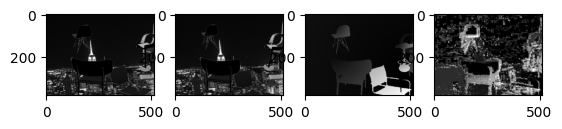

In [ ]:
flow=H_search('img1.jpg','img2.jpg','GT1.npy')